<a href="https://colab.research.google.com/github/Sithija97/Python-Projects/blob/main/Stage_4_beta_MoveNet_HumanPose_Kryptonions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**MoveNet** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import os 

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [4]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF.hub

In [5]:
model_name = "movenet_thunder" #@param ["movenet_thunder", "movenet_lightning"]

if model_name == "movenet_lightning":
  module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/3")
  input_size = 192
elif model_name == "movenet_thunder":
  module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/3")
  input_size = 256
else:
  raise ValueError("Unsupported model name: %s" % model_name)

movenet = module.signatures['serving_default']

## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

=============== Extracting relevent points from tensor ===============
[[[[0.304108   0.49054137 0.69441307]
   [0.29468098 0.49030042 0.54268783]
   [0.2955468  0.47630882 0.5343831 ]
   [0.2937511  0.47474462 0.24805327]
   [0.2981283  0.43763602 0.41581964]
   [0.35477847 0.4968949  0.656072  ]
   [0.3668687  0.38052434 0.6868498 ]
   [0.44955692 0.47666055 0.4963022 ]
   [0.4713284  0.3830103  0.41539228]
   [0.54844517 0.46409315 0.37182862]
   [0.55174714 0.41299725 0.21740699]
   [0.5128023  0.45852378 0.6824323 ]
   [0.5094943  0.38759482 0.78687173]
   [0.629234   0.49088195 0.48863852]
   [0.6288812  0.35329798 0.7591628 ]
   [0.7335723  0.48544714 0.62024593]
   [0.73462677 0.31126347 0.6102124 ]]]]
=============== Extracting relevent points from tensor ===============
[[[[0.2551097  0.47510266 0.7181188 ]
   [0.24658012 0.47707984 0.58698666]
   [0.24445868 0.4625604  0.7362678 ]
   [0.24748541 0.4635093  0.12100533]
   [0.24382368 0.42465124 0.5105397 ]
   [0.33218622 0.48

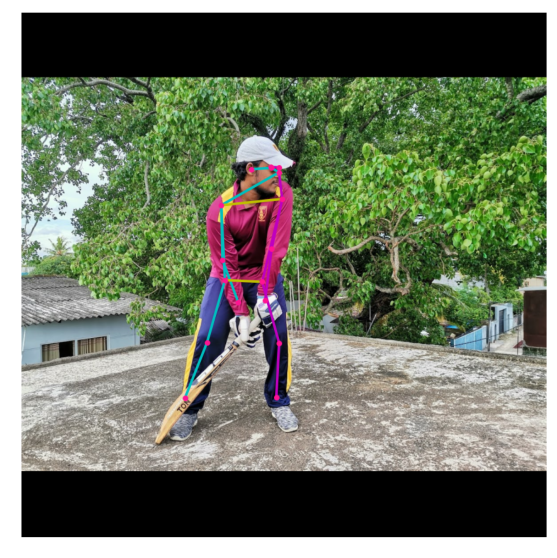

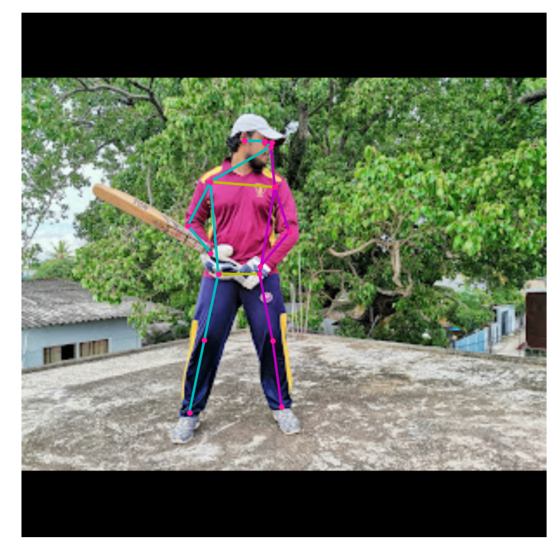

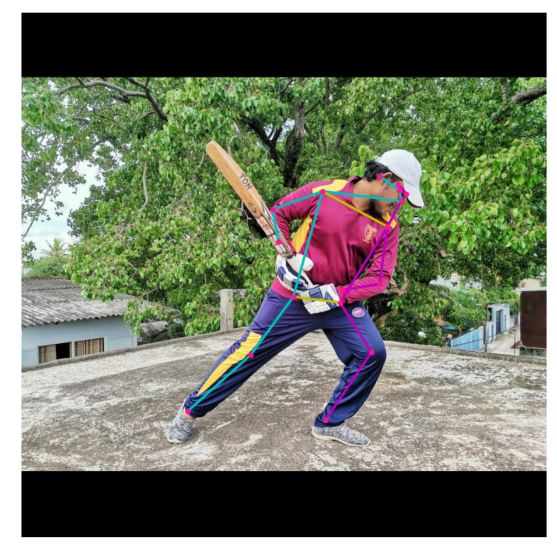

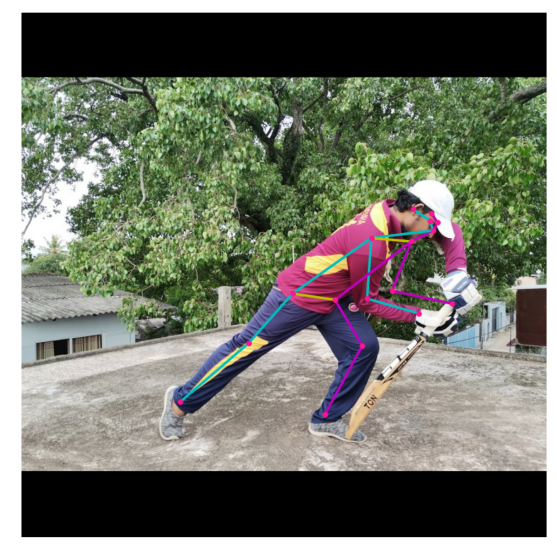

In [7]:
# Changed by @Sithijs_Shehara

# shotlist = ['https://www.cricketbio.com/wp-content/uploads/2020/12/front-foot-shots-in-cricket-1536x1045.jpg']
shotlist = ['https://lh3.googleusercontent.com/wa5y46GKQ_eRlEh6LjnyKJaGGsl0W9fuwiReRDdD3bQD4m8IMWO4pjpjuk-Ra-PNoV-0cG41gV7hD44HxElHK3ndClNmv0e7ml5BPhb9zPVsDyBkAlRzx-al4DlGV2LvFl31cVDgpjvu5iiTMh7GzVjc0_FuBJP_jHSnoOR9fkWgqj3STTfgR1AWm462P1EBUzZRyUIlRFVGmbd_uUbWddw4pYPTof3OEORpyfeMd6f9iNx29CTaUdkakFWMJQF4ML58ahxt7HNjaB2fzzSH2meDxze7g6I7wbGS_9Uxzw4DyBFLLk4d1AOFJdWRmk0SU4EdwP-45iSWu09oSw6OqVpGoK0fkkPkQytC9IQ7JwngQ-4LFgN3UfVgC-Yx06M6Yy48RsV8q9kxkGmn3MAl1YyTj7A9cIvRJvcKchc6ZHzq2frMvyb0SFK19pNDLkrfshNtZbqYfNwTqfotVgmSICNVXYCbqMtEMhbHL751lxPIuB3PdiwLg6900DAH1TFGaDWH49-5MLHHfdikurY7biWS95xL3Pk-WdQzU-v8v_DUAwHEmxUpFqCgRUg_kxsz87COOMKWpQ3KJ1wiU0qUVI0M8fAN4PdMa1DsYfO1Bt8egHJRvKz4ZFOo5v6irwKuGiNcPofNTv5L4QO1SWe5SCZ4gXb5DoLFmT65yLY2iqi5FG3rpWhFfmT_l4OgSCwAMMYq7qF4kPUzXMmSJ2XSNNXZ=w1185-h889-no?authuser=0',
            'https://lh3.googleusercontent.com/eP7A1-u8yruhWVvo44n16B1M9yrC93iNJPrK6egOzJaYX2VKFjX-zr0TLyzvW2aw2zTe_xJWd3pNu5FyWoZYMO_AC39cmoEifLzfFZADZ8ZpeXkrYQxYWLguldpU6hWVd8CONOkOP1jqSsWzi43FjT4bEAaCnL33EPUcqF5YFzgbvdQDAeV0WRRuMYovf6msEbRZbI-aPBIYCBtuvjuD5U0RCKy3xQ-TaZO_aMr6V8--ipQzz5BmXMjOAQZI94UVq_091jU64zNH3C7kZ7zy4k_4BNeCFJWtCSK1AATjxXOXkcUIbjhX-XeRSomhyGyJ0cu-Q337CFtbnOzRm_4Y-uYSa9jx7QXSTQ4MeL-224zJNPAkHh2j8R2STWGyWVlI9_EQKjl3KTT3D6z_BDU1PqN0GyALF6eTxduOssHHBoc_jjzI-XJfFlPbOIBZWQfWB-wu9tjRmanxib1zjATYbD56A4gA5xBWkmSUzcXWc9HZCHT4inJMORXvRjiGywvnovAO2eBIBx9jicOEP6phU6neOXkrQc-ZPqO5f8rsDF7QCpsVc9AGkchCDzWmd-fxq0fa_VvYODlg4TtCgRlJZc4yT_99SO0dNZY1wPAoK-lyobHuq-5aU0xWyTyzuoavDWtGJbpuChVz2H-Y8rkTNLPuNPZ_j0ifocTht7Fvo3unTKgQfI5z-UudqppEVoFdGmUi5w9smPcqiNRt6lQVNZxo=w303-h227-no?authuser=0',
            'https://lh3.googleusercontent.com/GKhLJ-m95W5hblh8ko0yLnUCnQaZ5ZehciN1cVs8DrUOR9pmJBwyJ5_Fz83MLJj1tPEH7GKw6uBgB57_hxl3T8W0T0oV44C_V1rU6S6PM8_6PRybVD6SvzE4I30xY9-W8MWgrpDt9ZHTZc3JZxh38zYZ1XS3AW5nCFWkALa_yEZvtQKRtR0wOl9_ldkpiia_r8ZMnPn570FDkhIuYWIFf4GqQtf5X1Q0899MOB-g4ibF9BSk5JfGKdFXYkVlNMqsr1_UP26RKFiZzqmREqeH_b8Eok1IpGuARHbLwyOCX4iqQVlwm8snx8A_iUfEdz0WVhmFmPN467wBqvGswOw9c3fps8Yxl1_nPkwBsTUZTD32brlE2bRWkSfOz7d69SW3aAFfRlpbkk7F8LK6ibosMXg1xwyx-CgFSSQSvhFrdMxzEDF1G4GZNdH4KJbb5CxxJ5mmeNb0ZswyiPSg3CW0f4H7CxbpGIzkvf4OIW4vX4OUvmF3kKJN_5dLFvTQ2QXlrcIdy0p8-C_tqhoqlh5dgZhtN1-xPJMOZJwgRDbnXCfgeNnijSlCyHYX3chu-YoDFw3I3KSv5JXHE1CT49rs4zNobObuPY2YMgE9bFc97FPXYTph5bbHpM8i6UuQ6Kh_nFLmZEtldx-jBWhNMr7ghIZnnDhsLVAgsvonnDhpfrF23e7rGmKXJtgHyksGMgnflRJ_rb_Omd2HPtRnGipOYOcO=w1185-h889-no?authuser=0',
            'https://lh3.googleusercontent.com/TZegaHwBRpk9W4MC1X_nNg7v6zLqdp3rxnmcMjmhELoIm3DYslx2AZP84YUqnq195zbqfYvrLAqZXOlqA1ZfPeuIkaA3FqLX4ddM1XlQ5lze8TwPE3gi_geonupAoQfoKv9OdnnQlrV8_kMgwFhMYdShHTBXPW19iYEroS7nBYiYokcQOdK4PXoFAyEMQZEw-nmYH0-X50rYox69Tp68YqvEHrBhl2ogQn3SbsJ8d20Xxv1cWKV55dP9ekQgiqH5T7qcMxz7jLzLBi_DLrk_37HDQnLa4FH-mkQN9XgqaoG0EnDcasd5GGMbMBUGTWmJ-3Ll28lRvbrRsOu2Rs9xZOJZ2gnMbnm3avJhP2vmy4S-J4KvOlAC_P7AOh6RqmLJzNY5fXd9yWLjVTrzIjt1q8UQtfECH8-qv0yeq-0eZppk5UPnuS3rhIp3GsJvRCvXf70_jwVvHTRyCVPBFZgXeQg_7xs_N_CLa6XE1WqVcyc24FPwDUmcoOm-j-SzNjuvA_P28zLTq2LDGioX2t0LgUcKB2jPcTG54B2WvJFu1TTv3fOTX68yRDPkax9KFCXuwp5xPx4upDcTNbhx34lExVbXPgO2SfnKODY4MfEYD-uEm_gG2Pk7osIyy71WwO5OAucpSPOQk6M0hQ-k5R9zOc0_hwP-LAOnCYCqszNEE7LBQch5OsVWhTOmbAvWdwVlqtqZpu1hUy2w_OBb3G-d3sZe=w1185-h889-no?authuser=0']

for url in shotlist:
  cmd='curl -o input_image.jpeg {} --silent'.format(url)
  os.system(cmd)

  # Load the input image.
  image_path = 'input_image.jpeg'
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image)

  # Resize and pad the image to keep the aspect ratio and fit the expected size.
  input_image = tf.expand_dims(image, axis=0)
  input_image = tf.cast(tf.image.resize_with_pad(
    input_image, input_size, input_size), dtype=tf.int32)

  # Run model inference.
  outputs = movenet(input_image)
  # Output is a [1, 1, 17, 3] tensor.
  keypoint_with_scores = outputs['output_0']

  # Added - Extracting relevent points from tensor
  print('=============== Extracting relevent points from tensor ===============')

  # Visualize the predictions with image.
  display_image = tf.expand_dims(image, axis=0)
  display_image = tf.cast(tf.image.resize_with_pad(
      display_image, 1280, 1280), dtype=tf.int32)
  output_overlay = draw_prediction_on_image(
      np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

  plt.figure(figsize=(10, 10))
  plt.imshow(output_overlay)
  _ = plt.axis('off')

  # print(keypoint_with_scores)
  array = keypoint_with_scores.numpy()
  print(array)